In [1]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

print(keras.__version__)

from numpy.random import seed
seed(123)


2.7.0
2.7.0


In [2]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('Dane/adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

/var/folders/3t/bh3b870n50l8_xwgnc5hdq900000gn/T/ipykernel_72517/1016998575.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_set = pd.read_csv('Dane/adult/adult.data', sep=", ",header = None)
/var/folders/3t/bh3b870n50l8_xwgnc5hdq900000gn/T/ipykernel_72517/1016998575.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test_set = pd.read_csv('Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape

(30162, 41)


(15060, 41)

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

from keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dropout(0.4))
model.add(Dense(50,activation="sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(10,activation="sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="Adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=5, callbacks=[lrate, history_Adam, early_stopping])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               4200      
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 50)                5050      
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 10)                510       
                                                                 
 dropout_5 (Dropout)         (None, 10)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

2022-06-01 22:10:36.872930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


943/943 [==============================] - ETA: 0s - loss: 0.5737 - accuracy: 0.7405

2022-06-01 22:10:42.929109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


943/943 [==============================] - 7s 8ms/step - loss: 0.5737 - accuracy: 0.7405 - val_loss: 0.5305 - val_accuracy: 0.7543 - lr: 1.0000e-04
Epoch 2/5
943/943 [==============================] - 7s 8ms/step - loss: 0.5128 - accuracy: 0.7543 - val_loss: 0.4556 - val_accuracy: 0.7543 - lr: 1.0000e-04
Epoch 3/5
943/943 [==============================] - 8s 8ms/step - loss: 0.4466 - accuracy: 0.7891 - val_loss: 0.3968 - val_accuracy: 0.8192 - lr: 1.0000e-04
Epoch 4/5
943/943 [==============================] - 8s 8ms/step - loss: 0.4077 - accuracy: 0.8128 - val_loss: 0.3731 - val_accuracy: 0.8347 - lr: 1.0000e-04
Epoch 5/5
943/943 [==============================] - 8s 8ms/step - loss: 0.3891 - accuracy: 0.8243 - val_loss: 0.3616 - val_accuracy: 0.8393 - lr: 1.0000e-04


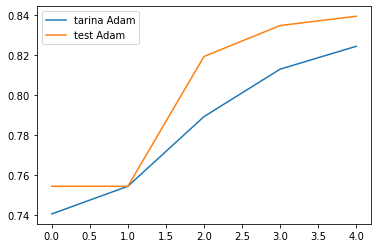

In [6]:
plt.plot(history_Adam.history['accuracy'], label = "tarina Adam")
plt.plot(history_Adam.history['val_accuracy'], label = "test Adam")


plt.legend()
plt.show()

# Zad.
Do poniższego modelu dodaj
```python
model.add(Dropout(0.8))
```
w każdej warstwie.

Zwizualizuj wyniki:

* porównaj krzywe uczenia
* narysuj granice decyzyjne (dane są w 2D)

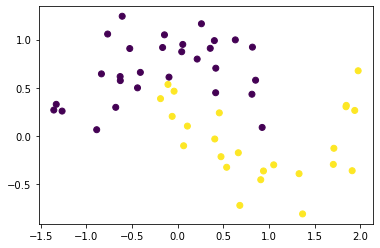

In [7]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.2, random_state=5)

n_train=53
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

plt.scatter(X_train[:,0],X_train[:,1], c=y_train)
plt.show()

In [8]:
from keras.callbacks import History


history_Adam = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dropout(0.8))
model.add(Dense(500,activation="sigmoid"))
model.add(Dropout(0.8))
model.add(Dense(200,activation="sigmoid"))
model.add(Dropout(0.8))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1000)              3000      
                                                                 
 dropout_6 (Dropout)         (None, 1000)              0         
                                                                 
 dense_9 (Dense)             (None, 500)               500500    
                                                                 
 dropout_7 (Dropout)         (None, 500)               0         
                                                                 
 dense_10 (Dense)            (None, 200)               100200    
                                                                 
 dropout_8 (Dropout)         (None, 200)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                

2022-06-01 22:11:39.841677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 282ms/step - loss: 0.8604 - accuracy: 0.5849 - val_loss: 0.7762 - val_accuracy: 0.4468
Epoch 2/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.9524 - accuracy: 0.5472 - val_loss: 0.7498 - val_accuracy: 0.4468


2022-06-01 22:11:40.528369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 3/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.9366 - accuracy: 0.5849 - val_loss: 0.7206 - val_accuracy: 0.4468
Epoch 4/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.8702 - accuracy: 0.4906 - val_loss: 0.7023 - val_accuracy: 0.4468
Epoch 5/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.9322 - accuracy: 0.4717 - val_loss: 0.6900 - val_accuracy: 0.4468
Epoch 6/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.8112 - accuracy: 0.6038 - val_loss: 0.6855 - val_accuracy: 0.4468
Epoch 7/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.7148 - accuracy: 0.6038 - val_loss: 0.6811 - val_accuracy: 0.4468
Epoch 8/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.7429 - accuracy: 0.4906 - val_loss: 0.6766 - val_accuracy: 0.4468
Epoch 9/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.7502 - accuracy: 0.6038 - val_loss: 0.6747 - val_accuracy: 0.4468
Epoch 10/1000

Epoch 61/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.3757 - accuracy: 0.8679 - val_loss: 0.4498 - val_accuracy: 0.7872
Epoch 62/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.3817 - accuracy: 0.8679 - val_loss: 0.4514 - val_accuracy: 0.7872
Epoch 63/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.2844 - accuracy: 0.8868 - val_loss: 0.4487 - val_accuracy: 0.7872
Epoch 64/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.2679 - accuracy: 0.8868 - val_loss: 0.4458 - val_accuracy: 0.8085
Epoch 65/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.3031 - accuracy: 0.8491 - val_loss: 0.4459 - val_accuracy: 0.8085
Epoch 66/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.3640 - accuracy: 0.8491 - val_loss: 0.4431 - val_accuracy: 0.8085
Epoch 67/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.3066 - accuracy: 0.9245 - val_loss: 0.4400 - val_accuracy: 0.8085
Epoch 

2/2 [==============================] - 0s 27ms/step - loss: 0.1688 - accuracy: 0.9245 - val_loss: 0.4433 - val_accuracy: 0.8298
Epoch 119/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.2945 - accuracy: 0.9057 - val_loss: 0.4426 - val_accuracy: 0.8298
Epoch 120/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.3308 - accuracy: 0.8868 - val_loss: 0.4469 - val_accuracy: 0.8298
Epoch 121/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.3008 - accuracy: 0.8302 - val_loss: 0.4527 - val_accuracy: 0.8298
Epoch 122/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.2595 - accuracy: 0.9245 - val_loss: 0.4609 - val_accuracy: 0.8298
Epoch 123/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.2270 - accuracy: 0.9057 - val_loss: 0.4680 - val_accuracy: 0.8298
Epoch 124/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.1646 - accuracy: 0.9434 - val_loss: 0.4718 - val_accuracy: 0.8298
Epoch 125/1000

2/2 [==============================] - 0s 28ms/step - loss: 0.2635 - accuracy: 0.9245 - val_loss: 0.4128 - val_accuracy: 0.8085
Epoch 176/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.2450 - accuracy: 0.8868 - val_loss: 0.4167 - val_accuracy: 0.8298
Epoch 177/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.2428 - accuracy: 0.9245 - val_loss: 0.4211 - val_accuracy: 0.8298
Epoch 178/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.1682 - accuracy: 0.9434 - val_loss: 0.4221 - val_accuracy: 0.8298
Epoch 179/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.2481 - accuracy: 0.9057 - val_loss: 0.4222 - val_accuracy: 0.8298
Epoch 180/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.2313 - accuracy: 0.9057 - val_loss: 0.4219 - val_accuracy: 0.8298
Epoch 181/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.2196 - accuracy: 0.9245 - val_loss: 0.4224 - val_accuracy: 0.8298
Epoch 182/1000

2/2 [==============================] - 0s 26ms/step - loss: 0.1809 - accuracy: 0.9245 - val_loss: 0.3966 - val_accuracy: 0.8298
Epoch 233/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.1487 - accuracy: 0.9623 - val_loss: 0.3972 - val_accuracy: 0.8085
Epoch 234/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.1684 - accuracy: 0.9434 - val_loss: 0.3967 - val_accuracy: 0.8298
Epoch 235/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.1500 - accuracy: 0.9623 - val_loss: 0.3945 - val_accuracy: 0.8298
Epoch 236/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.1984 - accuracy: 0.9245 - val_loss: 0.3944 - val_accuracy: 0.8298
Epoch 237/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.1867 - accuracy: 0.9434 - val_loss: 0.3934 - val_accuracy: 0.8298
Epoch 238/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.2235 - accuracy: 0.8868 - val_loss: 0.3934 - val_accuracy: 0.8298
Epoch 239/1000

2/2 [==============================] - 0s 26ms/step - loss: 0.1606 - accuracy: 0.9434 - val_loss: 0.3598 - val_accuracy: 0.8511
Epoch 290/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.1377 - accuracy: 0.9623 - val_loss: 0.3609 - val_accuracy: 0.8511
Epoch 291/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.1695 - accuracy: 0.9245 - val_loss: 0.3587 - val_accuracy: 0.8511
Epoch 292/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.1348 - accuracy: 0.9434 - val_loss: 0.3554 - val_accuracy: 0.8511
Epoch 293/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.1633 - accuracy: 0.9623 - val_loss: 0.3535 - val_accuracy: 0.8511
Epoch 294/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.1311 - accuracy: 0.9623 - val_loss: 0.3520 - val_accuracy: 0.8511
Epoch 295/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.1424 - accuracy: 0.9434 - val_loss: 0.3510 - val_accuracy: 0.8511
Epoch 296/1000

2/2 [==============================] - 0s 26ms/step - loss: 0.1428 - accuracy: 0.9434 - val_loss: 0.2961 - val_accuracy: 0.8511
Epoch 347/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.1297 - accuracy: 0.9434 - val_loss: 0.2938 - val_accuracy: 0.8511
Epoch 348/1000
2/2 [==============================] - 0s 24ms/step - loss: 0.1371 - accuracy: 0.9623 - val_loss: 0.2908 - val_accuracy: 0.8511
Epoch 349/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.1236 - accuracy: 0.9434 - val_loss: 0.2893 - val_accuracy: 0.8511
Epoch 350/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.1358 - accuracy: 0.9623 - val_loss: 0.2882 - val_accuracy: 0.8511
Epoch 351/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.1633 - accuracy: 0.9245 - val_loss: 0.2903 - val_accuracy: 0.8511
Epoch 352/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0843 - accuracy: 0.9434 - val_loss: 0.2930 - val_accuracy: 0.8723
Epoch 353/1000

2/2 [==============================] - 0s 26ms/step - loss: 0.1068 - accuracy: 0.9434 - val_loss: 0.2674 - val_accuracy: 0.8723
Epoch 404/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0594 - accuracy: 1.0000 - val_loss: 0.2656 - val_accuracy: 0.8723
Epoch 405/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0900 - accuracy: 0.9623 - val_loss: 0.2644 - val_accuracy: 0.8723
Epoch 406/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.1212 - accuracy: 0.9623 - val_loss: 0.2602 - val_accuracy: 0.8723
Epoch 407/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.1141 - accuracy: 0.9434 - val_loss: 0.2526 - val_accuracy: 0.8723
Epoch 408/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.1339 - accuracy: 0.9434 - val_loss: 0.2485 - val_accuracy: 0.8723
Epoch 409/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0788 - accuracy: 0.9623 - val_loss: 0.2439 - val_accuracy: 0.8723
Epoch 410/1000

2/2 [==============================] - 0s 27ms/step - loss: 0.0610 - accuracy: 0.9811 - val_loss: 0.1928 - val_accuracy: 0.9149
Epoch 461/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0595 - accuracy: 0.9811 - val_loss: 0.1926 - val_accuracy: 0.9149
Epoch 462/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.1751 - accuracy: 0.9434 - val_loss: 0.1949 - val_accuracy: 0.9149
Epoch 463/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0754 - accuracy: 0.9623 - val_loss: 0.1977 - val_accuracy: 0.8936
Epoch 464/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0678 - accuracy: 0.9623 - val_loss: 0.2000 - val_accuracy: 0.8936
Epoch 465/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0837 - accuracy: 0.9811 - val_loss: 0.2005 - val_accuracy: 0.8936
Epoch 466/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0750 - accuracy: 0.9623 - val_loss: 0.2015 - val_accuracy: 0.8936
Epoch 467/1000

2/2 [==============================] - 0s 32ms/step - loss: 0.0476 - accuracy: 0.9811 - val_loss: 0.1541 - val_accuracy: 0.9149
Epoch 518/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0700 - accuracy: 0.9434 - val_loss: 0.1546 - val_accuracy: 0.9149
Epoch 519/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0513 - accuracy: 0.9811 - val_loss: 0.1551 - val_accuracy: 0.9149
Epoch 520/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0788 - accuracy: 0.9811 - val_loss: 0.1546 - val_accuracy: 0.9149
Epoch 521/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0828 - accuracy: 0.9811 - val_loss: 0.1541 - val_accuracy: 0.9149
Epoch 522/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0767 - accuracy: 0.9434 - val_loss: 0.1542 - val_accuracy: 0.9149
Epoch 523/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0547 - accuracy: 0.9811 - val_loss: 0.1547 - val_accuracy: 0.9149
Epoch 524/1000

2/2 [==============================] - 0s 28ms/step - loss: 0.0454 - accuracy: 0.9811 - val_loss: 0.1732 - val_accuracy: 0.9362
Epoch 575/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0525 - accuracy: 0.9811 - val_loss: 0.1699 - val_accuracy: 0.9362
Epoch 576/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0613 - accuracy: 0.9811 - val_loss: 0.1678 - val_accuracy: 0.9362
Epoch 577/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0320 - accuracy: 1.0000 - val_loss: 0.1669 - val_accuracy: 0.9362
Epoch 578/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0175 - accuracy: 1.0000 - val_loss: 0.1658 - val_accuracy: 0.9362
Epoch 579/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0753 - accuracy: 0.9811 - val_loss: 0.1645 - val_accuracy: 0.9149
Epoch 580/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0147 - accuracy: 1.0000 - val_loss: 0.1638 - val_accuracy: 0.9149
Epoch 581/1000

2/2 [==============================] - 0s 28ms/step - loss: 0.0413 - accuracy: 0.9811 - val_loss: 0.1572 - val_accuracy: 0.9362
Epoch 632/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0138 - accuracy: 1.0000 - val_loss: 0.1584 - val_accuracy: 0.9362
Epoch 633/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0329 - accuracy: 0.9811 - val_loss: 0.1586 - val_accuracy: 0.9149
Epoch 634/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0296 - accuracy: 0.9811 - val_loss: 0.1593 - val_accuracy: 0.9149
Epoch 635/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0510 - accuracy: 0.9811 - val_loss: 0.1587 - val_accuracy: 0.9149
Epoch 636/1000
2/2 [==============================] - 0s 38ms/step - loss: 0.0208 - accuracy: 0.9811 - val_loss: 0.1576 - val_accuracy: 0.9149
Epoch 637/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0310 - accuracy: 0.9811 - val_loss: 0.1567 - val_accuracy: 0.9362
Epoch 638/1000

2/2 [==============================] - 0s 27ms/step - loss: 0.0425 - accuracy: 0.9811 - val_loss: 0.1782 - val_accuracy: 0.9362
Epoch 689/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0219 - accuracy: 0.9811 - val_loss: 0.1818 - val_accuracy: 0.9362
Epoch 690/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.1857 - val_accuracy: 0.9362
Epoch 691/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0229 - accuracy: 0.9811 - val_loss: 0.1874 - val_accuracy: 0.9362
Epoch 692/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0540 - accuracy: 0.9811 - val_loss: 0.1870 - val_accuracy: 0.9362
Epoch 693/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.1858 - val_accuracy: 0.9362
Epoch 694/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0561 - accuracy: 0.9811 - val_loss: 0.1832 - val_accuracy: 0.9362
Epoch 695/1000

2/2 [==============================] - 0s 27ms/step - loss: 0.0517 - accuracy: 0.9623 - val_loss: 0.1884 - val_accuracy: 0.9362
Epoch 746/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0428 - accuracy: 0.9811 - val_loss: 0.1880 - val_accuracy: 0.9362
Epoch 747/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.1863 - val_accuracy: 0.9362
Epoch 748/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0163 - accuracy: 1.0000 - val_loss: 0.1845 - val_accuracy: 0.9362
Epoch 749/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0510 - accuracy: 0.9811 - val_loss: 0.1817 - val_accuracy: 0.9362
Epoch 750/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0169 - accuracy: 1.0000 - val_loss: 0.1799 - val_accuracy: 0.9362
Epoch 751/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0493 - accuracy: 0.9811 - val_loss: 0.1806 - val_accuracy: 0.9362
Epoch 752/1000

2/2 [==============================] - 0s 26ms/step - loss: 0.0472 - accuracy: 0.9623 - val_loss: 0.1761 - val_accuracy: 0.9362
Epoch 803/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0157 - accuracy: 1.0000 - val_loss: 0.1802 - val_accuracy: 0.9362
Epoch 804/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0143 - accuracy: 1.0000 - val_loss: 0.1831 - val_accuracy: 0.9362
Epoch 805/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0242 - accuracy: 0.9811 - val_loss: 0.1830 - val_accuracy: 0.9362
Epoch 806/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0353 - accuracy: 0.9811 - val_loss: 0.1821 - val_accuracy: 0.9362
Epoch 807/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.1810 - val_accuracy: 0.9362
Epoch 808/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0495 - accuracy: 0.9811 - val_loss: 0.1795 - val_accuracy: 0.9362
Epoch 809/1000

2/2 [==============================] - 0s 27ms/step - loss: 0.0154 - accuracy: 1.0000 - val_loss: 0.1867 - val_accuracy: 0.9362
Epoch 860/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0435 - accuracy: 0.9623 - val_loss: 0.1885 - val_accuracy: 0.9362
Epoch 861/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0286 - accuracy: 0.9811 - val_loss: 0.1893 - val_accuracy: 0.9362
Epoch 862/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0694 - accuracy: 0.9811 - val_loss: 0.1929 - val_accuracy: 0.9362
Epoch 863/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.1048 - accuracy: 0.9811 - val_loss: 0.1981 - val_accuracy: 0.9362
Epoch 864/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.2040 - val_accuracy: 0.9362
Epoch 865/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0236 - accuracy: 0.9811 - val_loss: 0.2110 - val_accuracy: 0.9362
Epoch 866/1000

2/2 [==============================] - 0s 26ms/step - loss: 0.0225 - accuracy: 1.0000 - val_loss: 0.1631 - val_accuracy: 0.9574
Epoch 917/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0403 - accuracy: 0.9811 - val_loss: 0.1655 - val_accuracy: 0.9574
Epoch 918/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.1674 - val_accuracy: 0.9574
Epoch 919/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0295 - accuracy: 0.9811 - val_loss: 0.1696 - val_accuracy: 0.9574
Epoch 920/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.1717 - val_accuracy: 0.9574
Epoch 921/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0351 - accuracy: 0.9623 - val_loss: 0.1708 - val_accuracy: 0.9574
Epoch 922/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0169 - accuracy: 1.0000 - val_loss: 0.1698 - val_accuracy: 0.9574
Epoch 923/1000

2/2 [==============================] - 0s 26ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.1769 - val_accuracy: 0.9574
Epoch 974/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.1782 - val_accuracy: 0.9574
Epoch 975/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0237 - accuracy: 0.9811 - val_loss: 0.1782 - val_accuracy: 0.9574
Epoch 976/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0146 - accuracy: 1.0000 - val_loss: 0.1780 - val_accuracy: 0.9574
Epoch 977/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0303 - accuracy: 0.9811 - val_loss: 0.1783 - val_accuracy: 0.9574
Epoch 978/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0111 - accuracy: 1.0000 - val_loss: 0.1766 - val_accuracy: 0.9574
Epoch 979/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.1754 - val_accuracy: 0.9574
Epoch 980/1000

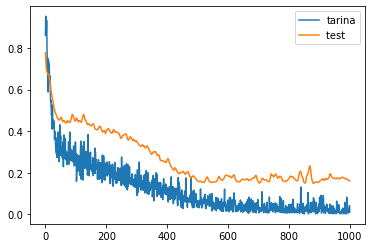

In [9]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")


plt.legend()
plt.show()

2022-06-01 22:12:18.206783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


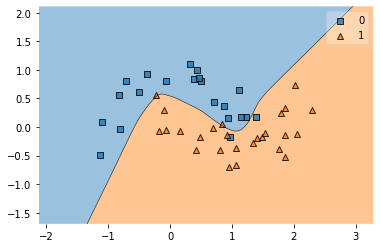

In [10]:
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()

# Zad.
Do poniższego modelu dodaj
 
```python
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
```

w każdej warstwie.

Zwizualizuj wyniki:

* porównaj krzywe uczenia
* narysuj granice decyzyjne (dane są w 2D)
* porównaj do powyższego eksperymentu

In [11]:
from keras.layers import BatchNormalization
from keras.layers import Activation

history_Adam = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.add(Dense(500,activation="sigmoid"))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.add(Dense(200,activation="sigmoid"))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1000)              3000      
                                                                 
 batch_normalization (BatchN  (None, 1000)             4000      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1000)              0         
                                                                 
 dropout_9 (Dropout)         (None, 1000)              0         
                                                                 
 dense_13 (Dense)            (None, 500)               500500    
                                                                 
 batch_normalization_1 (Batc  (None, 500)              2000      
 hNormalization)                                      

2022-06-01 22:14:28.087465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 335ms/step - loss: 0.7556 - accuracy: 0.5472 - val_loss: 0.8311 - val_accuracy: 0.4468
Epoch 2/1000
2/2 [==============================] - 0s 42ms/step - loss: 0.5489 - accuracy: 0.7547 - val_loss: 0.7915 - val_accuracy: 0.4468


2022-06-01 22:14:28.627992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 3/1000
2/2 [==============================] - 0s 42ms/step - loss: 0.5659 - accuracy: 0.7547 - val_loss: 0.7719 - val_accuracy: 0.4468
Epoch 4/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.4590 - accuracy: 0.7547 - val_loss: 0.7592 - val_accuracy: 0.4468
Epoch 5/1000
2/2 [==============================] - 0s 39ms/step - loss: 0.3543 - accuracy: 0.8679 - val_loss: 0.7538 - val_accuracy: 0.4468
Epoch 6/1000
2/2 [==============================] - 0s 40ms/step - loss: 0.3531 - accuracy: 0.8491 - val_loss: 0.7539 - val_accuracy: 0.4468
Epoch 7/1000
2/2 [==============================] - 0s 38ms/step - loss: 0.3071 - accuracy: 0.8679 - val_loss: 0.7552 - val_accuracy: 0.4468
Epoch 8/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.3838 - accuracy: 0.8302 - val_loss: 0.7582 - val_accuracy: 0.4468
Epoch 9/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.2468 - accuracy: 0.8868 - val_loss: 0.7555 - val_accuracy: 0.4468
Epoch 10/1000

Epoch 61/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.1372 - accuracy: 0.9623 - val_loss: 0.7891 - val_accuracy: 0.4468
Epoch 62/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.0986 - accuracy: 0.9811 - val_loss: 0.7931 - val_accuracy: 0.4468
Epoch 63/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.0560 - accuracy: 1.0000 - val_loss: 0.7999 - val_accuracy: 0.4468
Epoch 64/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.1485 - accuracy: 0.9245 - val_loss: 0.8162 - val_accuracy: 0.4468
Epoch 65/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.1514 - accuracy: 0.9623 - val_loss: 0.8294 - val_accuracy: 0.4468
Epoch 66/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.1162 - accuracy: 0.9623 - val_loss: 0.8427 - val_accuracy: 0.4468
Epoch 67/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.1135 - accuracy: 0.9811 - val_loss: 0.8530 - val_accuracy: 0.4468
Epoch 

2/2 [==============================] - 0s 37ms/step - loss: 0.0464 - accuracy: 0.9811 - val_loss: 1.4230 - val_accuracy: 0.4468
Epoch 119/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0473 - accuracy: 0.9811 - val_loss: 1.4151 - val_accuracy: 0.4468
Epoch 120/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0339 - accuracy: 1.0000 - val_loss: 1.4033 - val_accuracy: 0.4468
Epoch 121/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0620 - accuracy: 0.9811 - val_loss: 1.3957 - val_accuracy: 0.4468
Epoch 122/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.1829 - accuracy: 0.9057 - val_loss: 1.3881 - val_accuracy: 0.4468
Epoch 123/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.1061 - accuracy: 0.9623 - val_loss: 1.4526 - val_accuracy: 0.4468
Epoch 124/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.0682 - accuracy: 1.0000 - val_loss: 1.5423 - val_accuracy: 0.4468
Epoch 125/1000

2/2 [==============================] - 0s 39ms/step - loss: 0.1086 - accuracy: 0.9245 - val_loss: 1.7196 - val_accuracy: 0.4468
Epoch 176/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.0430 - accuracy: 1.0000 - val_loss: 1.7527 - val_accuracy: 0.4468
Epoch 177/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0327 - accuracy: 1.0000 - val_loss: 1.7992 - val_accuracy: 0.4468
Epoch 178/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0302 - accuracy: 1.0000 - val_loss: 1.8406 - val_accuracy: 0.4468
Epoch 179/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.1235 - accuracy: 0.9434 - val_loss: 1.8766 - val_accuracy: 0.4468
Epoch 180/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.1221 - accuracy: 0.9434 - val_loss: 1.9682 - val_accuracy: 0.4468
Epoch 181/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0340 - accuracy: 1.0000 - val_loss: 2.0313 - val_accuracy: 0.4468
Epoch 182/1000

2/2 [==============================] - 0s 33ms/step - loss: 0.0630 - accuracy: 0.9811 - val_loss: 1.1152 - val_accuracy: 0.4894
Epoch 233/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0471 - accuracy: 0.9811 - val_loss: 1.1255 - val_accuracy: 0.4894
Epoch 234/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0481 - accuracy: 0.9811 - val_loss: 1.1225 - val_accuracy: 0.4894
Epoch 235/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0268 - accuracy: 1.0000 - val_loss: 1.1299 - val_accuracy: 0.4894
Epoch 236/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.2009 - accuracy: 0.9245 - val_loss: 1.1772 - val_accuracy: 0.4894
Epoch 237/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.1760 - accuracy: 0.9434 - val_loss: 1.2021 - val_accuracy: 0.4681
Epoch 238/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0787 - accuracy: 0.9811 - val_loss: 1.1756 - val_accuracy: 0.4681
Epoch 239/1000

2/2 [==============================] - 0s 31ms/step - loss: 0.0965 - accuracy: 0.9623 - val_loss: 1.3771 - val_accuracy: 0.5957
Epoch 290/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0330 - accuracy: 0.9811 - val_loss: 1.3001 - val_accuracy: 0.6170
Epoch 291/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0268 - accuracy: 0.9811 - val_loss: 1.2038 - val_accuracy: 0.6170
Epoch 292/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0156 - accuracy: 1.0000 - val_loss: 1.1134 - val_accuracy: 0.6170
Epoch 293/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0409 - accuracy: 0.9811 - val_loss: 1.0365 - val_accuracy: 0.6170
Epoch 294/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.0864 - accuracy: 0.9623 - val_loss: 0.9966 - val_accuracy: 0.6596
Epoch 295/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.0379 - accuracy: 0.9623 - val_loss: 1.0018 - val_accuracy: 0.6596
Epoch 296/1000

2/2 [==============================] - 0s 30ms/step - loss: 0.0491 - accuracy: 0.9811 - val_loss: 0.7080 - val_accuracy: 0.7234
Epoch 347/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0243 - accuracy: 0.9811 - val_loss: 0.6739 - val_accuracy: 0.7447
Epoch 348/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0415 - accuracy: 0.9811 - val_loss: 0.6135 - val_accuracy: 0.7447
Epoch 349/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0312 - accuracy: 0.9811 - val_loss: 0.5370 - val_accuracy: 0.7660
Epoch 350/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0395 - accuracy: 1.0000 - val_loss: 0.4216 - val_accuracy: 0.7660
Epoch 351/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.1005 - accuracy: 0.9623 - val_loss: 0.3147 - val_accuracy: 0.8298
Epoch 352/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0842 - accuracy: 0.9811 - val_loss: 0.2431 - val_accuracy: 0.8723
Epoch 353/1000

2/2 [==============================] - 0s 31ms/step - loss: 0.0521 - accuracy: 0.9811 - val_loss: 0.1487 - val_accuracy: 0.9149
Epoch 404/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0438 - accuracy: 0.9811 - val_loss: 0.1280 - val_accuracy: 0.9362
Epoch 405/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0474 - accuracy: 0.9811 - val_loss: 0.1296 - val_accuracy: 0.9362
Epoch 406/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0964 - accuracy: 0.9623 - val_loss: 0.1375 - val_accuracy: 0.9362
Epoch 407/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.7573 - accuracy: 0.8113 - val_loss: 0.1406 - val_accuracy: 0.9362
Epoch 408/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0605 - accuracy: 0.9623 - val_loss: 0.1866 - val_accuracy: 0.9362
Epoch 409/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0559 - accuracy: 0.9623 - val_loss: 0.2645 - val_accuracy: 0.8511
Epoch 410/1000

2/2 [==============================] - 0s 33ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.1367 - val_accuracy: 0.9362
Epoch 461/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0125 - accuracy: 1.0000 - val_loss: 0.1354 - val_accuracy: 0.9362
Epoch 462/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0186 - accuracy: 1.0000 - val_loss: 0.1339 - val_accuracy: 0.9362
Epoch 463/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.1281 - accuracy: 0.9623 - val_loss: 0.1403 - val_accuracy: 0.9362
Epoch 464/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.0297 - accuracy: 1.0000 - val_loss: 0.1569 - val_accuracy: 0.9362
Epoch 465/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.1689 - val_accuracy: 0.9362
Epoch 466/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0551 - accuracy: 0.9811 - val_loss: 0.1816 - val_accuracy: 0.8936
Epoch 467/1000

2/2 [==============================] - 0s 31ms/step - loss: 0.0178 - accuracy: 1.0000 - val_loss: 0.1996 - val_accuracy: 0.9362
Epoch 518/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0205 - accuracy: 1.0000 - val_loss: 0.1914 - val_accuracy: 0.9362
Epoch 519/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0161 - accuracy: 1.0000 - val_loss: 0.1795 - val_accuracy: 0.9362
Epoch 520/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0790 - accuracy: 0.9811 - val_loss: 0.1692 - val_accuracy: 0.9362
Epoch 521/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0152 - accuracy: 1.0000 - val_loss: 0.1580 - val_accuracy: 0.9362
Epoch 522/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0521 - accuracy: 0.9811 - val_loss: 0.1539 - val_accuracy: 0.9362
Epoch 523/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0387 - accuracy: 0.9811 - val_loss: 0.1565 - val_accuracy: 0.9362
Epoch 524/1000

2/2 [==============================] - 0s 31ms/step - loss: 0.0251 - accuracy: 0.9811 - val_loss: 0.1240 - val_accuracy: 0.9574
Epoch 575/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.1276 - val_accuracy: 0.9362
Epoch 576/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.1001 - accuracy: 0.9434 - val_loss: 0.1423 - val_accuracy: 0.9362
Epoch 577/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0239 - accuracy: 0.9811 - val_loss: 0.1757 - val_accuracy: 0.9149
Epoch 578/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.2108 - val_accuracy: 0.9149
Epoch 579/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.2412 - val_accuracy: 0.9149
Epoch 580/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0262 - accuracy: 1.0000 - val_loss: 0.2612 - val_accuracy: 0.9149
Epoch 581/1000

2/2 [==============================] - 0s 31ms/step - loss: 0.0159 - accuracy: 1.0000 - val_loss: 0.2119 - val_accuracy: 0.9362
Epoch 632/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0914 - accuracy: 0.9811 - val_loss: 0.2049 - val_accuracy: 0.9362
Epoch 633/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0713 - accuracy: 0.9811 - val_loss: 0.1863 - val_accuracy: 0.9362
Epoch 634/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.1709 - val_accuracy: 0.9362
Epoch 635/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0143 - accuracy: 1.0000 - val_loss: 0.1600 - val_accuracy: 0.9362
Epoch 636/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 0.1516 - val_accuracy: 0.9362
Epoch 637/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0254 - accuracy: 0.9811 - val_loss: 0.1451 - val_accuracy: 0.9362
Epoch 638/1000

2/2 [==============================] - 0s 31ms/step - loss: 0.0155 - accuracy: 1.0000 - val_loss: 0.1749 - val_accuracy: 0.9362
Epoch 689/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.1778 - val_accuracy: 0.9362
Epoch 690/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.1516 - accuracy: 0.9623 - val_loss: 0.1772 - val_accuracy: 0.9362
Epoch 691/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.1976 - val_accuracy: 0.9362
Epoch 692/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0873 - accuracy: 0.9811 - val_loss: 0.2204 - val_accuracy: 0.9149
Epoch 693/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0333 - accuracy: 0.9811 - val_loss: 0.2296 - val_accuracy: 0.9149
Epoch 694/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0166 - accuracy: 0.9811 - val_loss: 0.2313 - val_accuracy: 0.9149
Epoch 695/1000

2/2 [==============================] - 0s 31ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.1789 - val_accuracy: 0.9362
Epoch 746/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.1725 - val_accuracy: 0.9362
Epoch 747/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0155 - accuracy: 1.0000 - val_loss: 0.1705 - val_accuracy: 0.9362
Epoch 748/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0768 - accuracy: 0.9623 - val_loss: 0.1651 - val_accuracy: 0.9787
Epoch 749/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0379 - accuracy: 0.9811 - val_loss: 0.1698 - val_accuracy: 0.9787
Epoch 750/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0434 - accuracy: 0.9811 - val_loss: 0.1978 - val_accuracy: 0.9574
Epoch 751/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0157 - accuracy: 1.0000 - val_loss: 0.2312 - val_accuracy: 0.9574
Epoch 752/1000

2/2 [==============================] - 0s 37ms/step - loss: 0.1717 - accuracy: 0.9057 - val_loss: 0.1818 - val_accuracy: 0.9362
Epoch 803/1000
2/2 [==============================] - 0s 39ms/step - loss: 0.0309 - accuracy: 0.9811 - val_loss: 0.2072 - val_accuracy: 0.9362
Epoch 804/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0579 - accuracy: 0.9811 - val_loss: 0.2626 - val_accuracy: 0.9149
Epoch 805/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.3035 - val_accuracy: 0.9149
Epoch 806/1000
2/2 [==============================] - 0s 38ms/step - loss: 0.0901 - accuracy: 0.9811 - val_loss: 0.2917 - val_accuracy: 0.8936
Epoch 807/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.2478 - val_accuracy: 0.9149
Epoch 808/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.2187 - val_accuracy: 0.9149
Epoch 809/1000

2/2 [==============================] - 0s 33ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.1638 - val_accuracy: 0.9362
Epoch 860/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0183 - accuracy: 0.9811 - val_loss: 0.1548 - val_accuracy: 0.9362
Epoch 861/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.1493 - val_accuracy: 0.9362
Epoch 862/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.1464 - val_accuracy: 0.9362
Epoch 863/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0261 - accuracy: 0.9811 - val_loss: 0.1517 - val_accuracy: 0.9362
Epoch 864/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.1371 - accuracy: 0.9623 - val_loss: 0.1511 - val_accuracy: 0.9362
Epoch 865/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.1586 - val_accuracy: 0.9362
Epoch 866/1000

2/2 [==============================] - 0s 34ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.1967 - val_accuracy: 0.9362
Epoch 917/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0139 - accuracy: 1.0000 - val_loss: 0.2033 - val_accuracy: 0.9362
Epoch 918/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.2049 - val_accuracy: 0.9362
Epoch 919/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0233 - accuracy: 0.9811 - val_loss: 0.2028 - val_accuracy: 0.9362
Epoch 920/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0504 - accuracy: 0.9811 - val_loss: 0.2064 - val_accuracy: 0.9362
Epoch 921/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.2134 - val_accuracy: 0.9362
Epoch 922/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0545 - accuracy: 0.9811 - val_loss: 0.2081 - val_accuracy: 0.9362
Epoch 923/1000

2/2 [==============================] - 0s 31ms/step - loss: 0.0136 - accuracy: 1.0000 - val_loss: 0.1848 - val_accuracy: 0.9574
Epoch 974/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0800 - accuracy: 0.9434 - val_loss: 0.2110 - val_accuracy: 0.9362
Epoch 975/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.2835 - val_accuracy: 0.9362
Epoch 976/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0462 - accuracy: 0.9811 - val_loss: 0.3770 - val_accuracy: 0.9149
Epoch 977/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.4808 - val_accuracy: 0.8936
Epoch 978/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0316 - accuracy: 0.9811 - val_loss: 0.5361 - val_accuracy: 0.8936
Epoch 979/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0258 - accuracy: 1.0000 - val_loss: 0.5529 - val_accuracy: 0.8936
Epoch 980/1000

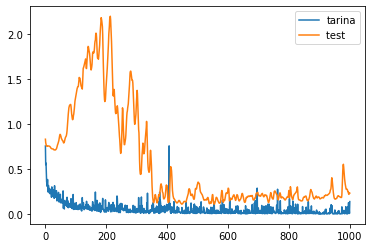

In [12]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")
plt.legend()
plt.show()

2022-06-01 22:15:15.208057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


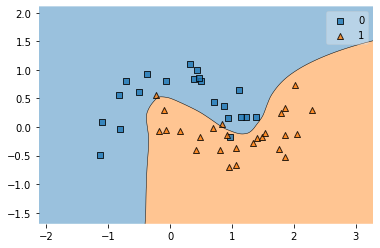

In [13]:
plot_decision_regions(X_test, y_test, model)
plt.show()

# Regularyzacja

# Zad.
Do modelu dodaj 
* 
```python
model.add(Dense( ... , activity_regularizer=l1(0.00001)))
```
* 
```python
model.add(Dense( ... , activity_regularizer=l1(0.0001)))
```

* 
```python
model.add(Dense( ... , activity_regularizer=l2(0.00001)))
```
* 
```python
model.add(Dense( ... , activity_regularizer=l2(0.0001)))
```

w każdej warstwie.

Zwizualizuj wyniki dla obu modeli.

In [14]:
from keras.callbacks import History
from keras.regularizers import l1


history_Adam_2 = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],), activity_regularizer=l1(0.00001)))
model.add(Dense(500,activation="sigmoid", activity_regularizer=l1(0.00001)))
model.add(Dense(200,activation="sigmoid", activity_regularizer=l1(0.00001)))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam_2])


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 1000)              3000      
                                                                 
 dense_17 (Dense)            (None, 500)               500500    
                                                                 
 dense_18 (Dense)            (None, 200)               100200    
                                                                 
 dense_19 (Dense)            (None, 1)                 201       
                                                                 
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000


2022-06-01 22:15:23.673613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 217ms/step - loss: 0.6729 - accuracy: 0.6038 - val_loss: 0.6779 - val_accuracy: 0.7447
Epoch 2/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.6923 - accuracy: 0.6792 - val_loss: 0.7101 - val_accuracy: 0.4468
Epoch 3/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.6865 - accuracy: 0.5000

2022-06-01 22:15:24.167213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 33ms/step - loss: 0.6655 - accuracy: 0.6415 - val_loss: 0.6369 - val_accuracy: 0.7234
Epoch 4/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.6283 - accuracy: 0.7547 - val_loss: 0.6187 - val_accuracy: 0.7447
Epoch 5/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.5992 - accuracy: 0.7547 - val_loss: 0.6152 - val_accuracy: 0.7447
Epoch 6/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.5546 - accuracy: 0.7925 - val_loss: 0.5638 - val_accuracy: 0.7447
Epoch 7/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.5165 - accuracy: 0.8302 - val_loss: 0.5327 - val_accuracy: 0.7447
Epoch 8/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.4707 - accuracy: 0.8302 - val_loss: 0.5054 - val_accuracy: 0.7447
Epoch 9/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.4199 - accuracy: 0.8491 - val_loss: 0.4843 - val_accuracy: 0.7447
Epoch 10/1000
2/2 [=======

Epoch 61/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.1723 - accuracy: 0.9623 - val_loss: 0.4505 - val_accuracy: 0.8298
Epoch 62/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.1704 - accuracy: 0.9245 - val_loss: 0.4412 - val_accuracy: 0.8298
Epoch 63/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.1733 - accuracy: 0.9245 - val_loss: 0.4367 - val_accuracy: 0.8298
Epoch 64/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.1699 - accuracy: 0.9245 - val_loss: 0.4557 - val_accuracy: 0.8298
Epoch 65/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.1661 - accuracy: 0.9623 - val_loss: 0.4550 - val_accuracy: 0.8298
Epoch 66/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.1670 - accuracy: 0.9623 - val_loss: 0.4465 - val_accuracy: 0.8298
Epoch 67/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.1624 - accuracy: 0.9623 - val_loss: 0.4484 - val_accuracy: 0.8298
Epoch 

2/2 [==============================] - 0s 29ms/step - loss: 0.0503 - accuracy: 1.0000 - val_loss: 0.1883 - val_accuracy: 0.9149
Epoch 119/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0458 - accuracy: 1.0000 - val_loss: 0.1913 - val_accuracy: 0.9149
Epoch 120/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0457 - accuracy: 1.0000 - val_loss: 0.1903 - val_accuracy: 0.9149
Epoch 121/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0438 - accuracy: 1.0000 - val_loss: 0.1940 - val_accuracy: 0.9149
Epoch 122/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0431 - accuracy: 1.0000 - val_loss: 0.1906 - val_accuracy: 0.9149
Epoch 123/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0420 - accuracy: 1.0000 - val_loss: 0.1859 - val_accuracy: 0.9149
Epoch 124/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0404 - accuracy: 1.0000 - val_loss: 0.1823 - val_accuracy: 0.9149
Epoch 125/1000

2/2 [==============================] - 0s 31ms/step - loss: 0.0182 - accuracy: 1.0000 - val_loss: 0.2053 - val_accuracy: 0.9149
Epoch 176/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0177 - accuracy: 1.0000 - val_loss: 0.2089 - val_accuracy: 0.9362
Epoch 177/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 0.2112 - val_accuracy: 0.9362
Epoch 178/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0186 - accuracy: 1.0000 - val_loss: 0.2097 - val_accuracy: 0.9362
Epoch 179/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 0.2037 - val_accuracy: 0.8936
Epoch 180/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0170 - accuracy: 1.0000 - val_loss: 0.2025 - val_accuracy: 0.8936
Epoch 181/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0175 - accuracy: 1.0000 - val_loss: 0.2035 - val_accuracy: 0.8936
Epoch 182/1000

2/2 [==============================] - 0s 29ms/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.2259 - val_accuracy: 0.8936
Epoch 233/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.2254 - val_accuracy: 0.8936
Epoch 234/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.2261 - val_accuracy: 0.8936
Epoch 235/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.2270 - val_accuracy: 0.8936
Epoch 236/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.2262 - val_accuracy: 0.8936
Epoch 237/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.2257 - val_accuracy: 0.9149
Epoch 238/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.2258 - val_accuracy: 0.9149
Epoch 239/1000

2/2 [==============================] - 0s 27ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.2443 - val_accuracy: 0.9149
Epoch 290/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.2446 - val_accuracy: 0.9149
Epoch 291/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.2452 - val_accuracy: 0.9149
Epoch 292/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.2458 - val_accuracy: 0.9149
Epoch 293/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.2463 - val_accuracy: 0.9149
Epoch 294/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.2466 - val_accuracy: 0.9149
Epoch 295/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.2460 - val_accuracy: 0.9149
Epoch 296/1000

2/2 [==============================] - 0s 27ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.2683 - val_accuracy: 0.9149
Epoch 347/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.2705 - val_accuracy: 0.9149
Epoch 348/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.2724 - val_accuracy: 0.9149
Epoch 349/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.2735 - val_accuracy: 0.9149
Epoch 350/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.2737 - val_accuracy: 0.9149
Epoch 351/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.2731 - val_accuracy: 0.9149
Epoch 352/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.2717 - val_accuracy: 0.9149
Epoch 353/1000

2/2 [==============================] - 0s 41ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.2952 - val_accuracy: 0.9149
Epoch 404/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.2959 - val_accuracy: 0.9149
Epoch 405/1000
2/2 [==============================] - 0s 42ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.2960 - val_accuracy: 0.9149
Epoch 406/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.2962 - val_accuracy: 0.9149
Epoch 407/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.2962 - val_accuracy: 0.9149
Epoch 408/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.2964 - val_accuracy: 0.9149
Epoch 409/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.2966 - val_accuracy: 0.9149
Epoch 410/1000

2/2 [==============================] - 0s 30ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.3241 - val_accuracy: 0.8936
Epoch 461/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.3245 - val_accuracy: 0.8936
Epoch 462/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.3251 - val_accuracy: 0.8936
Epoch 463/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.3254 - val_accuracy: 0.8936
Epoch 464/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.3257 - val_accuracy: 0.8936
Epoch 465/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.3259 - val_accuracy: 0.8936
Epoch 466/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.3263 - val_accuracy: 0.8936
Epoch 467/1000

2/2 [==============================] - 0s 26ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.3472 - val_accuracy: 0.8936
Epoch 518/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.3477 - val_accuracy: 0.8936
Epoch 519/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.3480 - val_accuracy: 0.8936
Epoch 520/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.3480 - val_accuracy: 0.8936
Epoch 521/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.3481 - val_accuracy: 0.8936
Epoch 522/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.3486 - val_accuracy: 0.8936
Epoch 523/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.3494 - val_accuracy: 0.8936
Epoch 524/1000

2/2 [==============================] - 0s 28ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.3677 - val_accuracy: 0.8936
Epoch 575/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.3679 - val_accuracy: 0.8936
Epoch 576/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.3681 - val_accuracy: 0.8936
Epoch 577/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.3685 - val_accuracy: 0.8936
Epoch 578/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.3694 - val_accuracy: 0.8936
Epoch 579/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.3701 - val_accuracy: 0.8936
Epoch 580/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.3706 - val_accuracy: 0.8936
Epoch 581/1000

2/2 [==============================] - 0s 26ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.3853 - val_accuracy: 0.8936
Epoch 632/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.3853 - val_accuracy: 0.8936
Epoch 633/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.3848 - val_accuracy: 0.8936
Epoch 634/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.3848 - val_accuracy: 0.8936
Epoch 635/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.3846 - val_accuracy: 0.8936
Epoch 636/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.3848 - val_accuracy: 0.8936
Epoch 637/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.3851 - val_accuracy: 0.8936
Epoch 638/1000

2/2 [==============================] - 0s 26ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.3956 - val_accuracy: 0.8936
Epoch 689/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.3961 - val_accuracy: 0.8936
Epoch 690/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.3968 - val_accuracy: 0.8936
Epoch 691/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.3969 - val_accuracy: 0.8936
Epoch 692/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.3970 - val_accuracy: 0.8936
Epoch 693/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.3967 - val_accuracy: 0.8936
Epoch 694/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.3963 - val_accuracy: 0.8936
Epoch 695/1000

2/2 [==============================] - 0s 26ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.4007 - val_accuracy: 0.8936
Epoch 746/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.4004 - val_accuracy: 0.8936
Epoch 747/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.3999 - val_accuracy: 0.8936
Epoch 748/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.3998 - val_accuracy: 0.8936
Epoch 749/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.3998 - val_accuracy: 0.8936
Epoch 750/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.3996 - val_accuracy: 0.8936
Epoch 751/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.4002 - val_accuracy: 0.8936
Epoch 752/1000

2/2 [==============================] - 0s 28ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.4051 - val_accuracy: 0.8936
Epoch 803/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.4046 - val_accuracy: 0.8936
Epoch 804/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.4037 - val_accuracy: 0.8936
Epoch 805/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.4032 - val_accuracy: 0.8936
Epoch 806/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.4027 - val_accuracy: 0.8936
Epoch 807/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.4025 - val_accuracy: 0.8936
Epoch 808/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.4031 - val_accuracy: 0.8936
Epoch 809/1000

2/2 [==============================] - 0s 26ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.4060 - val_accuracy: 0.8936
Epoch 860/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.4056 - val_accuracy: 0.8936
Epoch 861/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.4051 - val_accuracy: 0.8936
Epoch 862/1000
2/2 [==============================] - 0s 27ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.4045 - val_accuracy: 0.8936
Epoch 863/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.4047 - val_accuracy: 0.8936
Epoch 864/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.4047 - val_accuracy: 0.8936
Epoch 865/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.4050 - val_accuracy: 0.8936
Epoch 866/1000

2/2 [==============================] - 0s 26ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.4023 - val_accuracy: 0.9149
Epoch 917/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.4026 - val_accuracy: 0.9149
Epoch 918/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.4023 - val_accuracy: 0.9149
Epoch 919/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.4019 - val_accuracy: 0.9149
Epoch 920/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.4023 - val_accuracy: 0.9149
Epoch 921/1000
2/2 [==============================] - 0s 26ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.4026 - val_accuracy: 0.9149
Epoch 922/1000
2/2 [==============================] - 0s 25ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.4025 - val_accuracy: 0.9149
Epoch 923/1000

2/2 [==============================] - 0s 29ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.4023 - val_accuracy: 0.9149
Epoch 974/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.4008 - val_accuracy: 0.9149
Epoch 975/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.4007 - val_accuracy: 0.9149
Epoch 976/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.4011 - val_accuracy: 0.9149
Epoch 977/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.4014 - val_accuracy: 0.9149
Epoch 978/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.4018 - val_accuracy: 0.9149
Epoch 979/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.4024 - val_accuracy: 0.9149
Epoch 980/1000

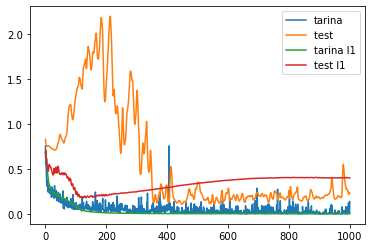

In [15]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")

# plt.plot(history_Adam_1.history['loss'], label = "tarina dropout")
# plt.plot(history_Adam_1.history['val_loss'], label = "test dropout")

plt.plot(history_Adam_2.history['loss'], label = "tarina l1")
plt.plot(history_Adam_2.history['val_loss'], label = "test l1")

plt.legend()
plt.show()

2022-06-01 22:16:02.709446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


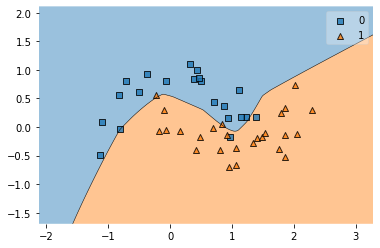

In [16]:
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()